<a href="https://colab.research.google.com/github/ShuriKimura0402/project-examples/blob/main/ECG_Practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt -y -q install tree
!pip install wfdb==2.2.1 scikit-learn==0.20.1 imbalanced-learn==0.4.3

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (50.4 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155680 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 688 kB/s 
   

In [2]:
!pip install chainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=dfe323795e6815917bf317e72c8995b6aadbe3cf8afd1b24493b72f3d4c52c73
  Stored in directory: /root/.cache/pip/wheels/c8/6a/6f/fd563166cc597e5206e375ea074ea836e5db5dd58421215672
Successfully built chainer


In [3]:
import os
import random
import numpy as np
import chainer
import scipy

In [4]:
import pandas as pd
import matplotlib
import seaborn as sn
import wfdb
import sklearn
import imblearn

In [6]:
dataset_root = './dataset'
download_dir = os.path.join(dataset_root, 'download')

In [7]:
wfdb.dl_database('mitdb', dl_dir=download_dir)

Created local base download directory: ./dataset/download
Finished downloading files


In [30]:
class Shuri_ECG_Practice(object):

    def __init__(
            self,
            dataset_root,
            window_size=720,  # 2 seconds
    ):
        self.dataset_root = dataset_root
        self.download_dir = os.path.join(self.dataset_root, 'download')
        self.window_size = window_size
        self.sample_rate = 360.
        
        self.train_record_list = [
            '101', '106', '108', '109', '112', '115', '116', '118', '119', '122',
            '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230'
        ]
        self.test_record_list = [
            '100', '103', '105', '111', '113', '117', '121', '123', '200', '210',
            '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234'
        ]
        
        self.labels = ['N', 'V']
        self.valid_symbols = ['N', 'L', 'R', 'e', 'j', 'V', 'E']
        self.label_map = {
            'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
            'V': 'V', 'E': 'V'
        }

    def _load_data(
            self,
            base_record,
            channel=0  # [0, 1]
    ):
        record_name = os.path.join(self.download_dir, str(base_record))
        signals, fields = wfdb.rdsamp(record_name)
        assert fields['fs'] == self.sample_rate

        annotation = wfdb.rdann(record_name, 'atr')
        symbols = annotation.symbol
        positions = annotation.sample
        return signals[:, channel], symbols, positions

    def _normalize_signal(
            self,
            signal,
            method='std'
    ):
        if method == 'minmax':

            min_val = np.min(signal)
            max_val = np.max(signal)
            return (signal - min_val) / (max_val - min_val)
        elif method == 'std':

            signal = (signal - np.mean(signal)) / np.std(signal)
            return signal
        else:
            raise ValueError("Invalid method: {}".format(method))

    def _segment_data(
            self,
            signal,
            symbols,
            positions
    ):
        X = []
        y = []
        sig_len = len(signal)
        for i in range(len(symbols)):
            start = positions[i] - self.window_size // 2
            end = positions[i] + self.window_size // 2
            if symbols[i] in self.valid_symbols and start >= 0 and end <= sig_len:
                segment = signal[start:end]
                assert len(segment) == self.window_size, "Invalid length"
                X.append(segment)
                y.append(self.labels.index(self.label_map[symbols[i]]))
        return np.array(X), np.array(y)

    def preprocess_dataset(
            self,
            normalize=True
    ):
        
        self._preprocess_dataset_core(self.train_record_list, "train", normalize)
       
        self._preprocess_dataset_core(self.test_record_list, "test", normalize)

    def _preprocess_dataset_core(
            self,
            record_list,
            mode="train",
            normalize=True
    ):
        Xs, ys = [], []
        save_dir = os.path.join(self.dataset_root, 'preprocessed', mode)
        for i in range(len(record_list)):
            signal, symbols, positions = self._load_data(record_list[i])
            if normalize:
                signal = self._normalize_signal(signal)
            X, y = self._segment_data(signal, symbols, positions)
            Xs.append(X)
            ys.append(y)
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, "X.npy"), np.vstack(Xs))

        np.save(os.path.join(save_dir, "y.npy"), np.concatenate(ys))

In [32]:
Shuri_ECG_Practice(dataset_root).preprocess_dataset()

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

In [34]:
X_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'X.npy'))
y_train = np.load(os.path.join(dataset_root, 'preprocessed', 'train', 'y.npy'))
X_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'X.npy'))
y_test = np.load(os.path.join(dataset_root, 'preprocessed', 'test', 'y.npy'))

In [36]:
print("X_train.shape = ", X_train.shape, " \t y_train.shape = ", y_train.shape)
print("X_test.shape = ", X_test.shape, " \t y_test.shape = ", y_test.shape)

X_train.shape =  (47738, 720)  	 y_train.shape =  (47738,)
X_test.shape =  (45349, 720)  	 y_test.shape =  (45349,)


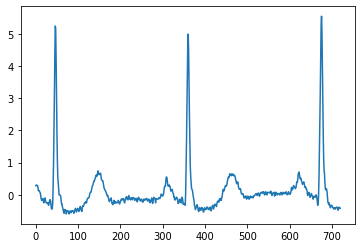

In [37]:
idx_n = np.where(y_train == 0)[0]
plt.plot(X_train[idx_n[0]])

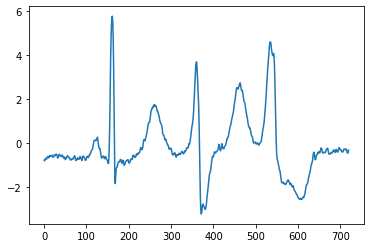

In [38]:
idx_s = np.where(y_train == 1)[0]
plt.plot(X_train[idx_s[0]])